Name: Josemaria Macedo Carrillo\
Ttile: Land Matrix Data Exploration\
Created: 08/07/23\
Last modified: 09/07/23\
DSI

The purpose of this notebook is to analyze data on Ukrainian agricultural
exports for October 2022 (busiest month according to BSGI). The main data sources
are the Black Sea Grain Initiative (BSGI) of the United
Nations and Import Genius (IG), a website that has trade data for different countries
including Ukraine.

In [1]:
import sys
sys.path.append('..')
import pandas as pd
from utils.get_data import get_data, import_data
from utils.record_linkage import rl_ig_bsgi
from utils.plot import cargo_grouping, plot_line, plot_crops, plot_pie, plot_stack_bar
from utils.clean_data import PRODUCTS_VAL, translate_column, rename_columns, create_columns, clean_column
from utils.transform_data import estimate_weights, standard_company_name, create_wide_table
from utils.record_linkage import record_linkage, unique_matches, filter_crop, find_matches
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import numpy as np
from utils.map import top_subsidiaries, top_parent, filter_country
import re
import copy
import os

### HELPER FUNCTIONS

In [2]:
def correct_name(series, name_dict):
    """
    Update column values from a dataframe with correct ones.

    Inputs:
        series (Series): column we want to update
        name_dict (dict): dictionary with incorrect names as keys and correct
            names as values.
    
    Returns: series with correct names.
    """
    return series.apply(lambda x: name_dict[x])

def filter_country(deals, country):
    """
    Filter land deals for a specific country

    Inputs:
        deals (DataFrame): dataframe with land deals data
        country (str): country name

    Returns (DataFrame): dataframe with country land locations
    """
    deals_c = deals.copy()
    deals_c.loc[:, "country_low"] = deals_c.loc[:, "Target country"].str.lower()
    deals_c = deals_c.loc[deals_c.loc[:, "country_low"].str.contains(country.lower(), na=False)]
    
    return deals_c

def extend_list(list, character):
    """
    Create new list with split text based on "character" parameter

    Inputs:
        list (lst): list of strings
        character (str): character to use to separate string values in list

    Returns (lst): new list with split text based on "character" parameter
    """
    new_lst = []
    for value in list:
        new_lst += value.split(character)

    return new_lst

def clean_list(list, pattern):
    """
    Create new list with clean text based on "pattern" parameter

    Inputs:
        list (lst): list of strings
        pattern (str): pattern we want to find and replace in each string value
            on the list

    Returns (lst): None. Makes changes in place in input "list".
    """
    for i, value in enumerate(list):
        match = re.search(pattern, value)
        if match:
            list[i] = match.group(0)

def parent_subsidiary_dict(parent_lst, deals_data, n_subsidiaries):
    """
    Create dictionary with parent companies as keys and subsidaries as values.

    Inputs:
        parent_lst (lst): list of parent companies
        deals_data (DataFrame): deals dataframe where we're going to look for
            subsidiaries
        n_subsidiaries (int): number of subsidiaries we want to get for parent
            company.

    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    subsidiaries_dict = {}

    for parent in parent_lst:
        subsidiaries_dict[parent] = top_subsidiaries(deals_data, parent,
                                                     n_subsidiaries)

    return subsidiaries_dict

def translate_subsidiaries(dict, source_lan, target_lan):
    """
    Create dictionary with translated subsidiaries' names as values.

    Inputs:
        dict (dict): dictionary with subsidarie names in English
        source_lan (str): current language code of values of dictionary
        target_lan (str): target language code we want to translate values to


    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    d_target = {}

    for parent, sub_lst in dict.items():
        target_lst = []
        for subsidiary in sub_lst:
            target_lst.append(GoogleTranslator(source_lan, target_lan).translate(subsidiary))
        d_target[parent] = target_lst

    return d_target

def manually_add_subsidiaries(original_dict, manual_dict):
    """
    Add subsidaries manually as values to company dictionary.

    Inputs:
        manual_dict (dict): dictionary with parent companies as keys and subsidaries
            as values.
        source_lan (str): current language code of values of dictionary
        target_lan (str): target language code we want to translate values to


    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    for parent, subsidiary_lst in manual_dict.items():
        for i, subsidiary in enumerate(subsidiary_lst):
            subsidiary_lst[i] = subsidiary.lower()
        if parent in original_dict:
            original_dict[parent] += manual_dict[parent]
        else:
            original_dict[parent] = manual_dict[parent]

    return original_dict

We get the data from IG for Asian countries and from BSGI for all countries

In [3]:
current_dir = os.getcwd()
path = os.path.join(os.path.dirname(current_dir), "data/ig_all_22-23.csv")
ig_asia = get_data("ig", path)
bsgi = get_data("bsgi")

We transform the country strings to the correct ones manually. This should be done
after doing record linkage but since we're not doing that we'll do it manually and then add it to
a function.

In [4]:
name_dict = {"в'єтнам": "в єтнам", "в єтнам": "в єтнам", "індія": "індія", "шрі-ланка": "шрі ланка", "шрі ланка": "шрі ланка"}
ig_asia["country"] = correct_name(ig_asia["country"], name_dict)
ig_asia["country"].unique()

array(['в єтнам', 'індія', 'шрі ланка'], dtype=object)

Now we filter just exports for crops that are included in BSGI so we can compare the volumes (otherwise we'll include exports for other commodities like metals that are included in IG but that aren't included in BSGI)

In [5]:
ig_asia = ig_asia[ig_asia["bsgi_commodity"]!= "Not in BSGI"]

print("IG tons:",ig_asia.loc[ig_asia.loc[:, "country"] == "в єтнам"]["weight_ton"].sum())
print("BSGI tons:",bsgi.loc[bsgi.loc[:, "country_en"] == "viet nam"]["weight_ton"].sum())

IG tons: 174997.27360000001
BSGI tons: 168789


We filter the BSGI data to include only months that are included in our IG data (August 2022 until March 2023)

In [6]:
bsgi_asia = bsgi[(bsgi["date"] >= "2022-08-01") & (bsgi["date"] < "2023-04-01") & ((bsgi["country_en"] == "india") | (bsgi["country_en"] == "viet nam") | (bsgi["country_en"] == "sri lanka"))]
bsgi_asia.head()

,status,,vessel_name,imo,departure_port,country_en,product,weight_ton,date,inspection_cleared,...,un_region,development_category,wfp,stranded,year,month,product_std,hs_code,product_std_gt,country
170,Outbound,857,PS QUEEN,9358319,Yuzhny/Pivdennyi,india,sunflower oil,42000,2023-03-30,9-Apr-2023,...,Asia-Pacific,developing,NaN,NaN,2023,3,sunflower,1512,соняшник,індія
198,Outbound,834,IOANNIS THEO,9565170,Odesa,viet nam,wheat,52000,2023-03-22,3-Apr-2023,...,Asia-Pacific,developing,NaN,NaN,2023,3,wheat,1001,пшениця,в'єтнам
313,Outbound,737,SEA MAJESTIC,9391153,Chornomorsk,india,sunflower oil,19176,2023-02-14,19-Feb-2023,...,Asia-Pacific,developing,NaN,NaN,2023,2,sunflower,1512,соняшник,індія
318,Outbound,732,OCEAN GLSR,9529516,Yuzhny/Pivdennyi,sri lanka,wheat,54268,2023-02-12,24-Feb-2023,...,Asia-Pacific,developing,NaN,NaN,2023,2,wheat,1001,пшениця,шрі ланка
394,Outbound,666,MRC SEDEF,9335032,Chornomorsk,india,sunflower oil,43000,2023-01-20,31-Jan-2023,...,Asia-Pacific,developing,NaN,NaN,2023,1,sunflower,1512,соняшник,індія


## TOTAL EXPORTS BY COMPANY

### STACKED BAR CHARTS

We have to create a column with standardized company names.

We're going to first get a list of the top 25 companies controlling agricultural land in Ukraine

In [7]:
deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")
deals_c = filter_country(deals, "ukraine")
parent_lst = top_parent(deals_c, 25)
parent_lst = extend_list(parent_lst, "|")

pattern = r'^.*?(?=#\d+#)'
clean_list(parent_lst, pattern)
parent_lst

/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_49934/180980090.py:1: DtypeWarning: Columns (139) have mixed types. Specify dtype option on import or set low_memory=False.
  deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")


['KSG Agro SA',
 'Xinjiang Production and Construction Corps (XPCC)',
 'China National Corporation for Overseas Economic Cooperation',
 'China-Ukraine International Engineering Cooperation Association Ltd.',
 'Kernel Holding S.A.',
 'UkrLandFarming PLC',
 'TNA Corporate Solutions LLC',
 'NCH Capital Inc.',
 'Ivanchyk V.P.',
 'Fairfax Financial Holdings LTD',
 'Sintal Agriculture Plc',
 'Public Investment Fund (PIF) of Saudi Arabia',
 'MHP S.E.',
 'Industrial Milk Company (IMC)',
 'System Capital Management (SCM)',
 'Smart Holding',
 'Agroton Public Limited',
 'MCB Agricole',
 'JSC "TAS Group"',
 'Myronivsky Hliboproduct PJSC',
 'MHP S.E.',
 'Nibulon',
 'SAS Investcompagnie',
 'UkrLandFarming PLC',
 'Extrar Holding Limeted',
 'YUTS-Agroproduct LLC',
 'Agro Ukraina AB',
 'Industrial Milk Company (IMC) S.A.',
 'Fintest trading co limited',
 'Ivory trade ITD.',
 'Inkosteel group LLC',
 'Renvior Trading Limited',
 'Epicentr-K LLC',
 'Logistical centre Kalynivka PJSC',
 'Nova Linia PJSC',
 '

Then we get a dictionary with the top 25 parent companies as keys and the top 20 subsidaries controlling agricultural land in Ukraine as values.

First we create the dictionary with the subsidiary names in English.

In [8]:
subsidiaries_dict = parent_subsidiary_dict(parent_lst, deals_c, 20)
subsidiaries_dict

/Users/jmacedoc/Documents/DSI/Ukraine Agricultural Exports/oakland-institute-ukraine/notebooks/../utils/map.py:83: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_c[column_name] = data_c["Top parent companies"].str.lower().str.contains(company, na=False)
/Users/jmacedoc/Documents/DSI/Ukraine Agricultural Exports/oakland-institute-ukraine/notebooks/../utils/map.py:83: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_c[column_name] = data_c["Top parent companies"].str.lower().str.contains(company, na=False)
/Users/jmacedoc/Documents/DSI/Ukraine Agricultural Exports/oakland-institute-ukraine/notebooks/../utils/map.py:83: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_c[column_name] = data_c["Top parent companies"].str

{'KSG Agro SA': array(['Unknown (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))',
        'KSG Dnipro', 'Souz-3 LLC', 'Argo-Golden LLC'], dtype=object),
 'Xinjiang Production and Construction Corps (XPCC)': array([], dtype=object),
 'China National Corporation for Overseas Economic Cooperation': array(['Unknown (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))'],
       dtype=object),
 'China-Ukraine International Engineering Cooperation Association Ltd.': array(['Unknown (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))'],
       dtype=object),
 'Ker

In [9]:
subsidiaries_uk = translate_subsidiaries(subsidiaries_dict, "en", "uk")
subsidiaries_uk

{'KSG Agro SA': ['Невідомо (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))',
  'КСГ Дніпро',
  'ТОВ «Союз-3».',
  'ТОВ «Арго-Голден».'],
 'Xinjiang Production and Construction Corps (XPCC)': [],
 'China National Corporation for Overseas Economic Cooperation': ['Невідомо (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))'],
 'China-Ukraine International Engineering Cooperation Association Ltd.': ['Невідомо (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))'],
 'Kernel Holding S.A.': ['Невідомо (Kernel Holding S.A., Україна, 38098)',
  'ТОВ «Дружба Нова».

In [10]:
subsidiaries_uk = {}

for parent, sub_lst in subsidiaries_dict.items():
    uk_lst = []
    for i, subsidiary in enumerate(sub_lst):
        uk_lst.append(GoogleTranslator("en", "uk").translate(subsidiary))
    subsidiaries_uk[parent] = uk_lst

subsidiaries_uk

{'KSG Agro SA': ['Невідомо (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))',
  'КСГ Дніпро',
  'ТОВ «Союз-3».',
  'ТОВ «Арго-Голден».'],
 'Xinjiang Production and Construction Corps (XPCC)': [],
 'China National Corporation for Overseas Economic Cooperation': ['Невідомо (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))'],
 'China-Ukraine International Engineering Cooperation Association Ltd.': ['Невідомо (China National Corporation for Overseas Economic Cooperation, China-Ukraine International Engineering Cooperation Association Ltd., KSG Agro SA, Xinjiang Production and Construction Corps (XPCC))'],
 'Kernel Holding S.A.': ['Невідомо (Kernel Holding S.A., Україна, 38098)',
  'ТОВ «Дружба Нова».

In [ ]:
S

Now we turn the values of the subsidiaries dictionary to lower case, as well as the shipper column in IG


In [11]:
for parent, subsidiary_lst in subsidiaries_uk.items():
    for i, subsidiary in enumerate(subsidiary_lst):
        subsidiary_lst[i] = subsidiary.lower()

ig_asia["shipper_low"] = ig_asia["shipper"].str.lower()
ig_asia["shipper_low"]

3       тов виробнича компанія золотий дракон україна ...
4       тов стивідорна компанія октябрьска україна 572...
26        тов потоки 49074 м дніпро вул байкальська буд 9
28      тов агрофірма добробут 39200 полтавська обл по...
29      тов івангородське 04050 м київ вул мельникова ...
                              ...                        
2414    тов байрак трейд 2022 україна 65078 одеська об...
2436    тов укролія вул шовковична будинок 42 44 офіс ...
2437    тов укролія вул шовковична будинок 42 44 офіс ...
2441    тов байрак трейд 2022 україна 65078 одеська об...
2455    тов байрак трейд 2022 україна 65078 одеська об...
Name: shipper_low, Length: 932, dtype: object

Manually add some companies

In [12]:
known_companies = {"Kernel Holding S.A.": ["ДРУЖБА НОВА", "ЕНСЕЛКО АГРО", "ПОДІЛЛЯ АГРОСЕРВІС", "КЕРНЕЛ", "Kernel", "ТОВ ДРУЖБА 41300 СУМСЬКА ОБЛ М КРОЛЕВЕЦЬ ВУЛ КООПЕРАТИВНА БУД 3 Б"], "UkrLandFarming PLC": ["VALINOR", "ДАКОР", "УКРЛЕНДФАРМІНГ", "ЮГТРАНЗИТСЕРВИС-АГРОПРОДУКТ", "АГРОКОМПАНІЯ ПРИКАРПАТТЯ", "UkrLandFarming"], "MHP S.E.": ["МХП", "ТОВ КАТЕРИНОПІЛЬСЬКИЙ ЕЛЕВАТОР 20505 ЧЕРКАСЬКА ОБЛ ЗВЕНІГОРОДСЬКИЙ Р Н СМТ ЄРКИ ВУЛ ГЕРОЇВ МАЙ", "MHP", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ КАТЕРИНОПІЛЬСЬКИЙ ЕЛЕВАТОР 20505 ЧЕРКАСЬКА ОБЛ ЗВЕНИГОРОДСЬКИЙ Р Н СЕЛИЩЕ МІСЬКОГО ТИПУ ЄРКИ", "ТОВ КАТЕРИНОПІЛЬСЬКИЙ ЕЛЕВАТОР 20505 ЧЕРКАСЬКА ОБЛ ЗВЕНИГОРОДСЬКИЙ Р Н СМТ ЄРКИ ВУЛ ГЕРОЇВ МАЙД"], "TNA Corporate Solutions LLC": ["ПІВДЕНЬ АГРО ІНВЕСТ", "ПТАХОФАБРИКА ПОДІЛЛЯ", "ПРИДНІПРОВСЬКА", "РАЙЗ-МАКСИМКО", "ПРИДНІПРОВСЬКЕ", "TNA", "ТОВ ПОДІЛЛЯ АГРОПРОДУКТ 23130 ВІННИЦЬКА ОБЛ ЖМЕРИНСЬКИЙ Р Н СМТ БРАЇЛІВ ВУЛ ЗАВОДСЬКА Б"], "NCH Capital Inc.": ["АГРОПРОСПЕРІС", "НХЦ", "NCH"], "Astarta Holding": ["АСТАРТА", "ДОБРОБУТ", "ПОЛТАВАЗЕРНОПРОДУКТ", "ХМІЛЬНИЦЬКЕ", "АГРО КА", "Astarta", "Agrofirm named after Dovzhenko", "ТОВ АГРОФІРМА ІМ ДОВЖЕНКА 38030 ПОЛТАВСЬКА ОБЛ МИРГОРОДСЬКИЙ Р Н С ЯРЕСЬКИ ВУЛ КОЗАЦЬКИЙ ШЛ", "Volochysk-Agro", "ТОВ ВОЛОЧИСЬК АГРО 31200 ХМЕЛЬНИЦЬКА ОБЛ ХМЕЛЬНИЦЬКИЙ Р Н М ВОЛОЧИСЬК ВУЛ ФРИДРИХІВС"], "Industrial Milk Company (IMC) S.A.": ["АГРОПРОГРЕС", "СЛОБОЖАНЩИНА АГРО", "АГРОКІМ", "БУРАТ АГРО", "ЛОСИНІВКА АГРО", "ИМЦ", "IMC"], "Public Investment Fund (PIF) of Saudi Arabia": ["SALIC", "АГРО ЛВ", "МРІЯ ФАРМІНГ", "PIF", "ПИФ", "ТОВ СІЕФДЖІ ТРЕЙДИНГ УКРАЇНА 47602 ТЕРНОПІЛЬСЬКА ОБЛ ТЕРНОПІЛЬСЬКИЙ Р Н СМТ КОЗОВА ВУ"], "Agroton Public Limited": ["АГРОТОН", "Agroton"], "Nibulon": ["НІБУЛОН", "Nibulon"], "System Capital Management (SCM)": ["АГРО ХОЛДИНГ МС", "System Capital Management", "SCM", "СЦМ"], "Louis Dreyfus": ["Louis Dreyfus"], "Cargill": ["Cargill", "ТОВ АТ КАРГІЛЛ 03150 УКРАЇНА М КИЇВ ВУЛИЦЯ ВЕЛИКА ВАСИЛЬКІВСЬКА БУД 139", "ТОВ АТ КАРГІЛЛ 03150 УКРАЇНА М КИЇВ ВУЛ ВЕЛИКА ВАСИЛЬКІВСЬКА БУД 139"], "Glencore": ["Glencore"], "Marubeni": ["Marubeni"], "Bunge": ["Bunge"], "Noble Resources": ["Noble Resources"], "Viterra Ukraine": ["Viterra", "ПІДПРИЄМСТВО З ІНОЗЕМНИМИ ІНВЕСТИЦІЯМИ ВАЙТЕРРА УКРАЇНА 03150 МІСТО КИЇВ ВУЛ ВЕЛИКА ВАСИЛЬКІВСЬКА БУДИНОК 100"], "Ardeon Tsentr": ["Ardeon", "ТОВ АРДЕОН ЦЕНТР 07301 КИЇВСЬКА ОБЛ М ВИШГОРОД ВУЛ ВАТУТІНА БУД 69 Г ОФІС 2/4"], "Allseeds Group": ["Allseeds", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ОЛСІДЗ ГРУП УКРАЇНА 04655 М КИЇВ ВУЛ ВЕРХНІЙ ВАЛ БУД 72"], "Delta Wilmar Ukraine": ["Delta Wilmar Ukraine", "ТОВ ДЕЛЬТА ВІЛМАР УКРАЇНА 65481 ОДЕСЬКА ОБЛ МІСТО ЮЖНЕ ВУЛИЦЯ ІНДУСТРІАЛЬНА БУДИНОК 6"], "Bioenergy-Vinnytsia": ["Bioenergy-Vinnytsia", "ТОВ БІОЕНЕРДЖІ ВІННИЦЯ 23130 ВІННИЦЬКА ОБЛ ЖМЕРИНСЬКИЙ Р Н СМТ БРАЇЛІВ ВУЛ ЗАВОДСЬКА БУ"], "SFGCU": ["State Food and Grain Corporation of Ukraine", "АКЦІОНЕРНЕ ТОВАРИСТВО ДЕРЖАВНА ПРОДОВОЛЬЧО ЗЕРНОВА КОРПОРАЦІЯ УКРАЇНИ 01033 М КИЇВ ВУЛ САКСАГАНСЬКОГО 1", "SFGCU"], "Karla Marksa 2": ["Karla Marksa", "ПП КАРЛА МАРКСА 2 41543 СУМСЬКА ОБЛ КОНОТОПСЬКИЙ РАЙОН С МІНАКОВЕ ВУЛ САДОВА БУД 6"], "Optimus Agro": ["Optimus Agro", "ТОВ ОПТІМУСАГРО ТРЕЙД 49033 ДНІПРОПЕТРОВСЬКА ОБЛ М ДНІПРО ПР Т БОГДАНА ХМЕЛЬНИЦЬКОГО Б", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ОПТІМУСАГРО ТРЕЙД 69014 ЗАПОРІЗЬКА ОБЛ МІСТО ЗАПОРІЖЖЯ ВУЛ ХАРЧОВА БУДИНОК 3"], "ADM Ukraine": ["ADM Ukraine", "Archer Daniels Midland", "ТОВ АДМ ЮКРЕЙН 04070 М КИЇВ ВУЛ ПЕТРА САГАЙДАЧНОГО БУД 16 А УКРАЇНА"], "Ossoyo": ["Ossoyo", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ОССОЙО УКРАЇНА 01054 МІСТО КИЇВ ВУЛ ГОНЧАРА ОЛЕСЯ БУДИНОК 35 ПРИМІЩЕННЯ", "ОССОЙО"], "D.Trading": ["D.Trading", "ТОВ Д ТРЕЙДІНГ 04119 М КИЇВ ВУЛИЦЯ ХОХЛОВИХ СІМ Ї БУДИНОК 8 ЛІТЕРА 20Д"], "HS Airlines": ["HS Airlines", "ТОВ ЕЙЧ ЕС ЕЙРЛАЙНС 65039 ОДЕСЬКА ОБЛ М ОДЕСА ВУЛ ТРАНСПОРТНА БУД 5/1"], "Willers": ["Willers", "ТОВ ВІЛЕРС 04053 М КИЇВ ВОЗНЕСЕНСЬКИЙ УЗВІЗ БУД 14 ОФ 16/7"], "Nimeri Hold": ["Nimeri Hold", "ТОВ НІМЕРІ ГОЛД 65048 ОДЕСЬКА ОБЛ М ОДЕСА ВУЛ КАНАТНА БУД 42 ОФ 975"], "Smartsystems": ["Smartsystems", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ СМАРТСИСТЕМС 54003 МИКОЛАЇВСЬКА ОБЛ М МИКОЛАЇВ ПР ЦЕНТРАЛЬНИЙ БУДИНОК 269/3"], "New Logist Ukraine": ["New Logist Ukraine", "ТОВ НЬЮ ЛОГІСТ ЮКРЕЙН 65005 М ОДЕСА ВУЛ БАЛКІВСЬКА БУД 108 КАБ 27"], "Trade Westend": ["Trade Westend", "ТОВ ТРЕЙД ВЕСТЕНД 79007 М ЛЬВІВ ВУЛ ШПИТАЛЬНА БУД 9 УКРАЇНА"], "Verkhivtsevsky Oil Extraction Plant 'Soloma'": ["Verkhivtsevsky Oil Extraction Plant", "Soloma", "ТОВ СОЛОМА 51660 ДНІПРОПЕТРОВСЬКА ОБЛ ВЕРХНЬОДНІПРОВСЬКИЙ Р ОН М ВЕРХІВЦЕВЕ"], "Korsun-Shevchenkivsky Grain Reception Enterprise": ["Korsun-Shevchenkivsky Grain Reception Enterprise", "ТОВ КОРСУНЬ ШЕВЧЕНКІВСЬКЕ ХЛІБОПРИЙМАЛЬНЕ ПІДПРИЄМСТВО 19402 ЧЕРКАСЬКА ОБЛ М КОРСУНЬ ШЕВЧ ЕНКІВСЬКИЙ ПРОВ ПРОМИСЛОВИЙ БУД 6"], "Tolans": ["Tolans", "ТОВ СТИВІДОРНА КОМПАНІЯ ОКТЯБРЬСКА УКРАЇНА 57214 МИКОЛАЇВСЬКА ОБЛ ВІТОВСЬКИЙ Р Н СЕЛО МІШКОВО ПОГОРІ", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ СТИВІДОРНА КОМПАНІЯ ОКТЯБРЬСК 57214 МИКОЛАЇВСЬКА ОБЛАСТЬ ВІТОВСЬКИЙ РАЙОН СЕЛО МІШКОВО ПОГОРІЛОВЕ"], "TH Novaagro": ["TH Novaagro", "ТОВ ТБ НОВААГРО 61002 М ХАРКІВ ВУЛ ЧЕРНИШЕВСЬКА БУД 66"], "Analytictrade": ["Analytictrade", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ АНАЛІТИКТРЕЙД 54001 МИКОЛАЇВСЬКА ОБЛ МІСТО МИКОЛАЇВ ВУЛ ШЕВЧЕНКА БУД 71 ОФІС"], "New Agro Podillya LLC": ["New Agro Podillya", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ НЬЮ АГРО ПОДІЛЛЯ 32207 ХМЕЛЬНИЦЬКА ОБЛ ХМЕЛЬНИЦЬКИЙ РН С ЯБЛУНІВКА ПРОВ МИРУ БУД 1"], "Group of companies Vitagro LLC": ["Vitagro", "ПП АГРАРНА КОМПАНІЯ 2004 31222 УКРАЇНА ХМЕЛЬНИЦЬКА ОБЛ ВОЛОЧИСЬКИЙ Р Н С ПОПІВЦІ ВУЛ ШК"], "Eridon PE": ["Eridon", "ТОВ ФІРМА ЕРІДОН 08467 КИЇВСЬКА ОБЛ ПЕРЕЯСЛАВ ХМЕЛЬНИЦЬКИЙ Р Н С ЧОПИЛКИ ВУЛ БОГДА"], "Vesele-Agro LLC": ["Vesele-Agro", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВЕСЕЛЕ АГРО УКРАЇНА 45611 ВОЛИНСЬКА ОБЛ ЛУЦЬКИЙ Р Н СЕЛО ВЕСЕЛЕ ВУЛ ТОРЧИНС"], "Kurland": ["Kurland", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ КУРЛАНД УКРАЇНА 23152 ВІННИЦЬКА ОБЛ ЖМЕРИНСЬКИЙ Р Н С ТЕЛЕЛИНЦІ ВУЛ ЦЕН"], "Vorozhbalatinvest LLC": ["Vorozhbalatinvest", "ТОВ ВОРОЖБАЛАТІНВЕСТ 42240 СУМСЬКА ОБЛ ЛЕБЕДИНСЬКИЙ РАЙОН С ВОРОЖБА ВУЛ СУМСЬКА БУД 1"], "MIR 12": ["MIR 12", "ТОВ МИР 12 41532 СУМСЬКА ОБЛ КОНОТОПСЬКИЙ Р Н С МАЗІВКА ВУЛ МИРУ БУД 14"], "Promin Podillya LLC": ["Promin Podillya", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ПРОМІНЬ ПОДІЛЛЯ УКРАЇНА 32625 ХМЕЛЬНИЦЬКА ОБЛ НОВОУШИЦЬКИЙ Р Н СЕЛО ПЕСЕЦЬ ВУЛ"], "Olyshchivka": ["Olyshchivka", "ТОВ ОЛИШІВКА 15575 ЧЕРНІГІВСЬКА ОБЛ ЧЕРНІГІВСЬК Р Н СМТ ОЛИШІВКА В ЧЕРНІГІВСЬКА Б"]}

subsidiaries_c = copy.deepcopy(subsidiaries_uk)

for parent, subsidiary_lst in known_companies.items():
    for i, subsidiary in enumerate(subsidiary_lst):
        subsidiary_lst[i] = subsidiary.lower()

    if parent in subsidiaries_c:
        subsidiaries_c[parent] += known_companies[parent]
    else:
        subsidiaries_c[parent] = known_companies[parent]

subsidiaries_c

{'KSG Agro SA': ['невідомо (china national corporation for overseas economic cooperation, china-ukraine international engineering cooperation association ltd., ksg agro sa, xinjiang production and construction corps (xpcc))',
  'ксг дніпро',
  'тов «союз-3».',
  'тов «арго-голден».'],
 'Xinjiang Production and Construction Corps (XPCC)': [],
 'China National Corporation for Overseas Economic Cooperation': ['невідомо (china national corporation for overseas economic cooperation, china-ukraine international engineering cooperation association ltd., ksg agro sa, xinjiang production and construction corps (xpcc))'],
 'China-Ukraine International Engineering Cooperation Association Ltd.': ['невідомо (china national corporation for overseas economic cooperation, china-ukraine international engineering cooperation association ltd., ksg agro sa, xinjiang production and construction corps (xpcc))'],
 'Kernel Holding S.A.': ['невідомо (kernel holding s.a., україна, 38098)',
  'тов «дружба нова».

In [13]:
ig_c = ig_asia.copy()
ig_c["company_std"] = standard_company_name(ig_asia["shipper_low"], subsidiaries_c)
ig_c["company_std"].unique()

array(['Other', 'Tolans', 'Astarta Holding', 'Kernel Holding S.A.',
       'Nimeri Hold', 'TH Novaagro', 'Willers',
       'Korsun-Shevchenkivsky Grain Reception Enterprise',
       'Ardeon Tsentr', 'Cargill', 'Group of companies Vitagro LLC',
       'Viterra Ukraine', 'Analytictrade',
       'Public Investment Fund (PIF) of Saudi Arabia', 'D.Trading',
       'Eridon PE', 'Bioenergy-Vinnytsia', 'Ossoyo', 'SFGCU',
       "Verkhivtsevsky Oil Extraction Plant 'Soloma'", 'Optimus Agro',
       'MHP S.E.', 'Trade Westend', 'Allseeds Group', 'MIR 12',
       'Olyshchivka', 'HS Airlines', 'Karla Marksa 2',
       'Vorozhbalatinvest LLC', 'New Agro Podillya LLC',
       'Promin Podillya LLC', 'Kurland', 'Vesele-Agro LLC',
       'Smartsystems', 'TNA Corporate Solutions LLC', 'ADM Ukraine',
       'Delta Wilmar Ukraine', 'New Logist Ukraine'], dtype=object)

We see how some of the top 10 companies are written in IG and in Land Matrix

In [14]:

print("Kernel subsidiaries (Land Matrix):\n", subsidiaries_c["Kernel Holding S.A."])
tempo = ig_c.copy()
tempo["kernel_bool"] = tempo["shipper_low"].isin(["кернел"])
tempo[tempo["kernel_bool"] == True]
tempo[tempo["company_std"] == "Kernel Holding S.A."]
# tempo["company_std"].unique()


# Assuming you have a DataFrame called 'deals_c'
deals_c.loc[deals_c["Top parent companies"].str.contains("Kernel"), ["Top parent companies"]]


Kernel subsidiaries (Land Matrix):
 ['невідомо (kernel holding s.a., україна, 38098)', 'тов «дружба нова».', 'тов «придніпровський край».', 'тов «енселко агро».', 'невідомо (kernel holding s.a., україна, 35574)', 'тов «поділля-агросервіс».', 'тов «калина».', 'тов «вишневе-агро».', 'ховтва allc', 'тов «агрополіс».', 'тов "агрофірма семереньки".', 'тов «агропідприємство рост».', 'тов «агрофірма «україна».', 'агро інвест україна', 'пп старший', 'тов «кочубій».', 'пп куликівські аграрні інвестиції', 'тов «агрофірма кочубій».', 'київська русь верфель тов', 'тов «агрофірма «вісла».', 'дружба нова', 'енселко агро', 'поділля агросервіс', 'кернел', 'kernel', 'тов дружба 41300 сумська обл м кролевець вул кооперативна буд 3 б']


,Top parent companies
575,Kernel Holding S.A.#908#
576,Kernel Holding S.A.#908#
582,Kernel Holding S.A.#908#
3052,Kernel Holding S.A.#908#
3349,Kernel Holding S.A.#908#
3350,Kernel Holding S.A.#908#
3351,Kernel Holding S.A.#908#
3352,Kernel Holding S.A.#908#
3353,Kernel Holding S.A.#908#
3354,Kernel Holding S.A.#908#


In [15]:
tempo[tempo["company_std"] == "Kernel Holding S.A."]


,product,hs_code,consignee,consignee_address,shipper,shipper_address,date,quantity,weight_kg,invoice_price_uah,...,vegetable,corn,sugar beet,mixed,sunflower,peas,barley,shipper_low,company_std,kernel_bool
31,пшениця і суміш пшениці та жита (меслин): - ін...,1001990000,UTF AG 32 ZUGERSTRASSE 6340 BAAR/ZUG SWITZERLAND,NaN,ТОВ ДРУЖБА 41300 СУМСЬКА ОБЛ М КРОЛЕВЕЦЬ ВУЛ К...,NaN,2023-03-28,NaN,6000000.0,28800000.0,...,False,False,False,False,False,False,False,тов дружба 41300 сумська обл м кролевець вул к...,Kernel Holding S.A.,False
608,"олії соняшникова, сафлорова або бавовняна та ї...",1512119100,INERCO TRADE S A RUE JULES GACHET 9 1260 NYON ...,NaN,ТОВ ЕНСЕЛКО АГРО 31134 ХМЕЛЬНИЦЬКА ОБЛ ХМЕЛЬНИ...,NaN,2023-01-30,NaN,6052100.0,209160576.0,...,False,False,False,False,True,False,False,тов енселко агро 31134 хмельницька обл хмельни...,Kernel Holding S.A.,False
648,"олії соняшникова, сафлорова або бавовняна та ї...",1512119100,INERCO TRADE S A RUE JULES GACHET 9 1260 NYON ...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 МІСТО КИЇВ ПРОВУЛОК ШЕВ...,NaN,2023-01-23,NaN,5504520.0,186107821.2,...,False,False,False,False,True,False,False,тов кернел трейд 01001 місто київ провулок шев...,Kernel Holding S.A.,False
649,"олії соняшникова, сафлорова або бавовняна та ї...",1512119100,INERCO TRADE S A RUE JULES GACHET 9 1260 NYON ...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 МІСТО КИЇВ ПРОВУЛОК ШЕВ...,NaN,2023-01-23,NaN,12000000.0,405720000.0,...,False,False,False,False,True,False,False,тов кернел трейд 01001 місто київ провулок шев...,Kernel Holding S.A.,False
650,"олії соняшникова, сафлорова або бавовняна та ї...",1512119100,INERCO TRADE S A RUE JULES GACHET 9 1260 NYON ...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 МІСТО КИЇВ ПРОВУЛОК ШЕВ...,NaN,2023-01-23,NaN,7000000.0,236670000.0,...,False,False,False,False,True,False,False,тов кернел трейд 01001 місто київ провулок шев...,Kernel Holding S.A.,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,"олії соняшникова, сафлорова або бавовняна та ї...",1512119100,INERCO TRADE S A RUE JULES GACHET 9 1260 NYON ...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛ ТАРАСА ШЕ...,NaN,2022-09-02,NaN,4000000.0,159600000.0,...,False,False,False,False,True,False,False,тов кернел трейд 01001 м київ провул тараса ше...,Kernel Holding S.A.,False
2252,"олії соняшникова, сафлорова або бавовняна та ї...",1512119100,INERCO TRADE S A RUE JULES GACHET 9 1260 NYON ...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛ ТАРАСА ШЕ...,NaN,2022-09-02,NaN,250000.0,9975000.0,...,False,False,False,False,True,False,False,тов кернел трейд 01001 м київ провул тараса ше...,Kernel Holding S.A.,False
2253,"олії соняшникова, сафлорова або бавовняна та ї...",1512119100,INERCO TRADE S A RUE JULES GACHET 9 1260 NYON ...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛ ТАРАСА ШЕ...,NaN,2022-09-02,NaN,250000.0,9975000.0,...,False,False,False,False,True,False,False,тов кернел трейд 01001 м київ провул тараса ше...,Kernel Holding S.A.,False
2254,"олії соняшникова, сафлорова або бавовняна та ї...",1512119100,INERCO TRADE S A RUE JULES GACHET 9 1260 NYON ...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛ ТАРАСА ШЕ...,NaN,2022-09-02,NaN,250000.0,9975000.0,...,False,False,False,False,True,False,False,тов кернел трейд 01001 м київ провул тараса ше...,Kernel Holding S.A.,False


In [16]:
for col in deals_c.columns:
    print(col)

Deal ID
Is public
Deal scope
Deal size
Target country
Current size under contract
Current size in operation (production)
Current negotiation status
Current implementation status
Fully updated
Top parent companies
Intended size (in ha)
Size under contract (leased or purchased area, in ha)
Size in operation (production, in ha)
Comment on land area
Intention of investment
Comment on intention of investment
Nature of the deal
Comment on nature of the deal
Negotiation status
Comment on negotiation status
Implementation status
Comment on implementation status
Purchase price
Purchase price currency
Purchase price area type
Purchase price area
Comment on purchase price
Annual leasing fee
Annual leasing fee currency
Annual leasing fee type
Annual leasing fee area
Comment on leasing fees
Contract farming
On leased / purchased
On leased area/farmers/households
Not on leased / purchased (out-grower)
Not on leased area/farmers/households (out-grower)
Comment on contract farming
Jobs created (total)

Now we convert the dataframe to a wide format so we can plot the stacked bar.

In [17]:
pivot = create_wide_table(ig_c, ["year", "month", "company_std"], ["weight_ton"], ["year", "month", "company_std"], True, {"weight_ton": "sum"})
pivot

company_std,date,ADM Ukraine,Allseeds Group,Analytictrade,Ardeon Tsentr,Astarta Holding,Bioenergy-Vinnytsia,Cargill,D.Trading,Delta Wilmar Ukraine,...,Smartsystems,TH Novaagro,TNA Corporate Solutions LLC,Tolans,Trade Westend,Verkhivtsevsky Oil Extraction Plant 'Soloma',Vesele-Agro LLC,Viterra Ukraine,Vorozhbalatinvest LLC,Willers
6,8/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9/2022,7500.0,17203.8,NaN,NaN,NaN,NaN,NaN,NaN,14802.0,...,NaN,NaN,8414.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/2022,NaN,NaN,NaN,7685.6,NaN,5873.9,NaN,NaN,NaN,...,9155.8,1388.5,NaN,NaN,NaN,NaN,3513.4,1553.1,3408.4,NaN
2,11/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6011.4,NaN,NaN,NaN,NaN,NaN,NaN
3,12/2022,NaN,811.4,3996.2,NaN,NaN,NaN,NaN,15000.0,NaN,...,NaN,1052.0,NaN,NaN,6793.3,6087.1,NaN,3964.8,NaN,NaN
0,1/2023,NaN,NaN,NaN,NaN,16391.0,7037.7,NaN,43324.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2/2023,NaN,NaN,631.6,NaN,NaN,NaN,21378.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18356.6,NaN,NaN
5,3/2023,NaN,NaN,NaN,13761.5,289.8,NaN,NaN,NaN,NaN,...,NaN,3306.8,NaN,6050.2,NaN,NaN,NaN,NaN,NaN,12001.5


In [18]:
for col in pivot.columns:
    if col != "date":
        print(col)



ADM Ukraine
Allseeds Group
Analytictrade
Ardeon Tsentr
Astarta Holding
Bioenergy-Vinnytsia
Cargill
D.Trading
Delta Wilmar Ukraine
Eridon PE
Group of companies Vitagro LLC
HS Airlines
Karla Marksa 2
Kernel Holding S.A.
Korsun-Shevchenkivsky Grain Reception Enterprise
Kurland
MHP S.E.
MIR 12
New Agro Podillya LLC
New Logist Ukraine
Nimeri Hold
Olyshchivka
Optimus Agro
Ossoyo
Other
Promin Podillya LLC
Public Investment Fund (PIF) of Saudi Arabia
SFGCU
Smartsystems
TH Novaagro
TNA Corporate Solutions LLC
Tolans
Trade Westend
Verkhivtsevsky Oil Extraction Plant 'Soloma'
Vesele-Agro LLC
Viterra Ukraine
Vorozhbalatinvest LLC
Willers


In [19]:
percentages = pivot.copy()
percentages = percentages.fillna(0)
date = percentages["date"]
percentage_df = percentages.drop(columns=["date"]).divide(percentages.drop(columns=["date"]).sum(axis=1), axis=0) * 100
percentage_df = percentage_df.round(2)
percentage_df["date"] = date
percentage_df

company_std,ADM Ukraine,Allseeds Group,Analytictrade,Ardeon Tsentr,Astarta Holding,Bioenergy-Vinnytsia,Cargill,D.Trading,Delta Wilmar Ukraine,Eridon PE,...,TH Novaagro,TNA Corporate Solutions LLC,Tolans,Trade Westend,Verkhivtsevsky Oil Extraction Plant 'Soloma',Vesele-Agro LLC,Viterra Ukraine,Vorozhbalatinvest LLC,Willers,date
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8/2022
7,7.39,16.96,0.00,0.00,0.00,0.00,0.00,0.00,14.59,0.00,...,0.00,8.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9/2022
1,0.00,0.00,0.00,3.76,0.00,2.87,0.00,0.00,0.00,1.34,...,0.68,0.00,0.00,0.00,0.00,1.72,0.76,1.67,0.00,10/2022
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,36.66,0.00,0.00,0.00,0.00,0.00,0.00,11/2022
3,0.00,0.84,4.15,0.00,0.00,0.00,0.00,15.59,0.00,0.62,...,1.09,0.00,0.00,7.06,6.33,0.00,4.12,0.00,0.00,12/2022
0,0.00,0.00,0.00,0.00,12.48,5.36,0.00,32.97,0.00,0.31,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1/2023
4,0.00,0.00,0.84,0.00,0.00,0.00,28.59,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,24.55,0.00,0.00,2/2023
5,0.00,0.00,0.00,21.94,0.46,0.00,0.00,0.00,0.00,0.00,...,5.27,0.00,9.64,0.00,0.00,0.00,0.00,0.00,19.13,3/2023


Now we plot the stacked bar with our wide format table we created earlier.

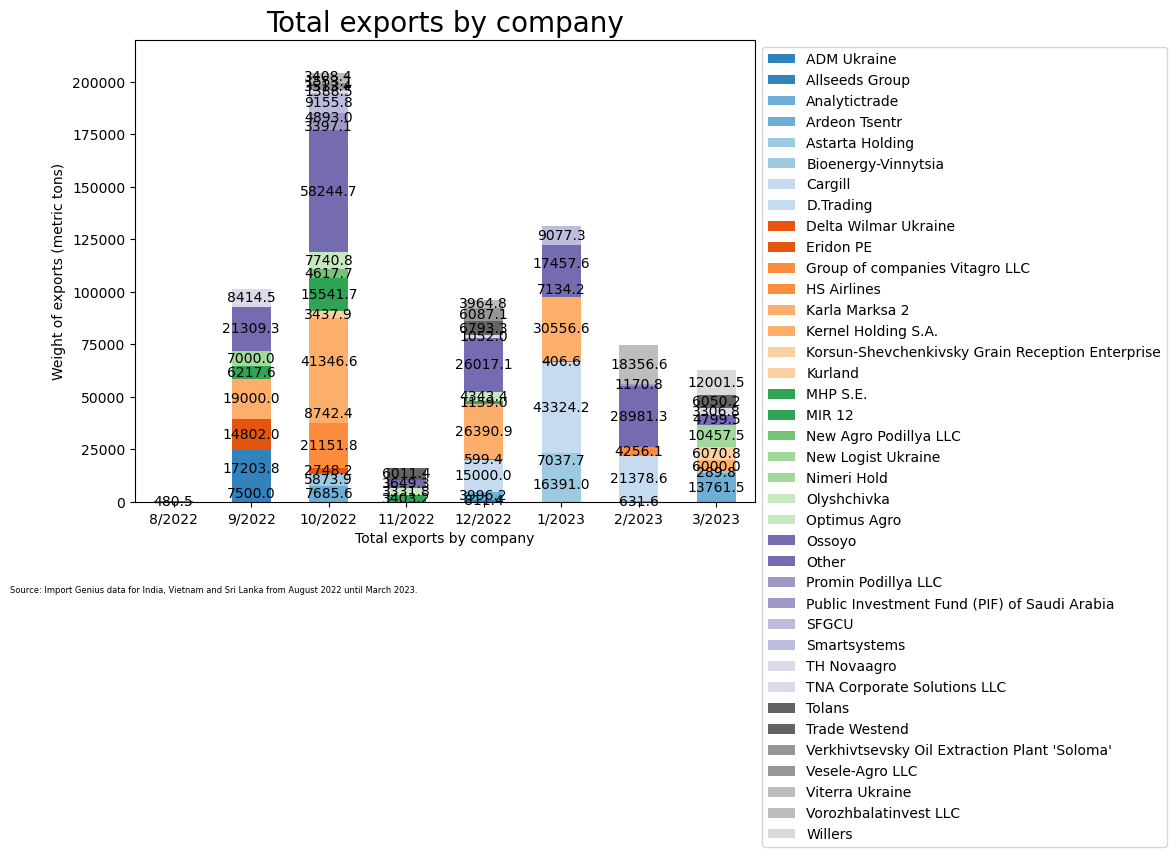

In [20]:
plot_stack_bar(pivot, "Total exports by company", "Weight of exports (metric tons)", "Total exports by company", "date", 220000, "Import Genius data for India, Vietnam and Sri Lanka from August 2022 until March 2023")

Now we do the same but with percentages

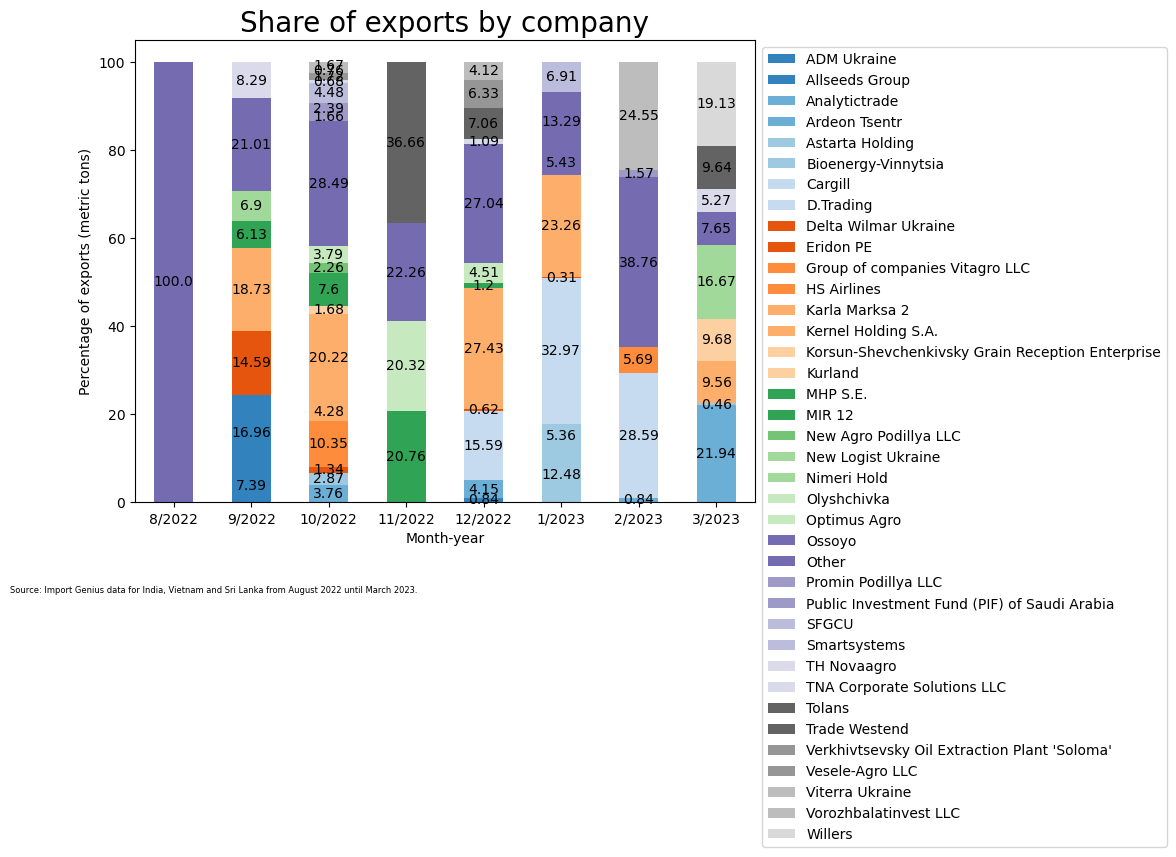

In [21]:
plot_stack_bar(percentage_df, "Month-year", "Percentage of exports (metric tons)", "Share of exports by company", "date", 105, "Import Genius data for India, Vietnam and Sri Lanka from August 2022 until March 2023")

We plot the same stacked bars but now by country

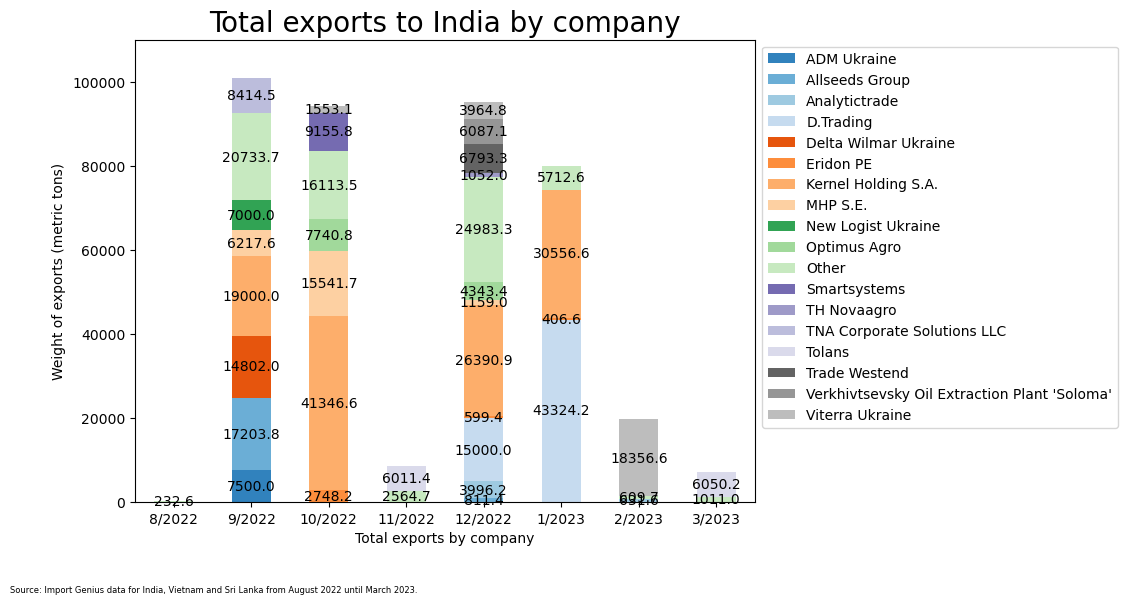

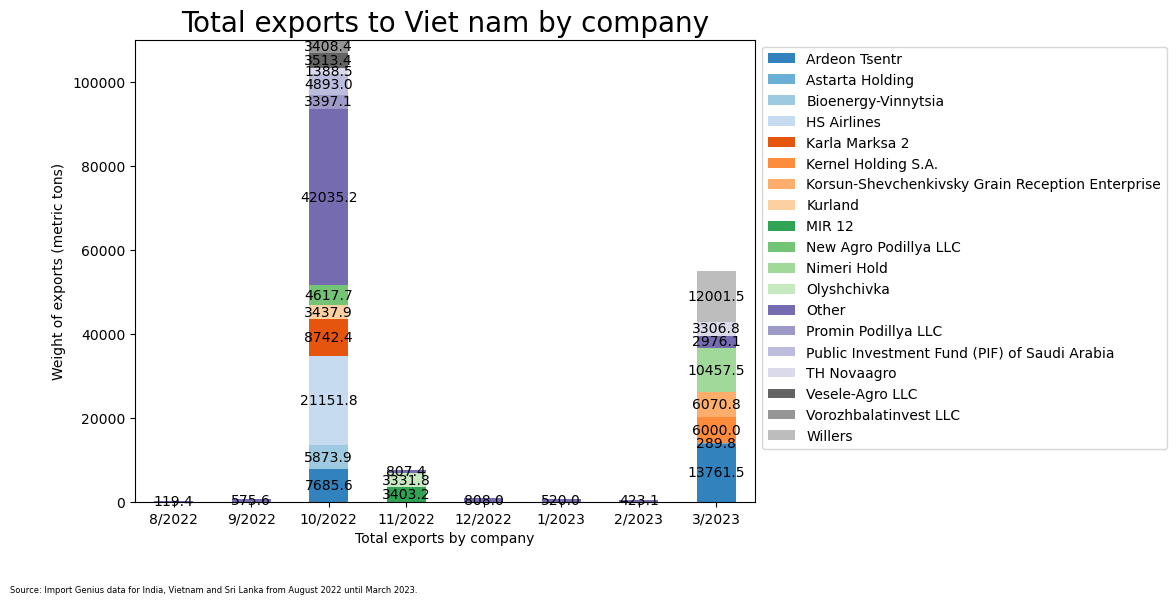

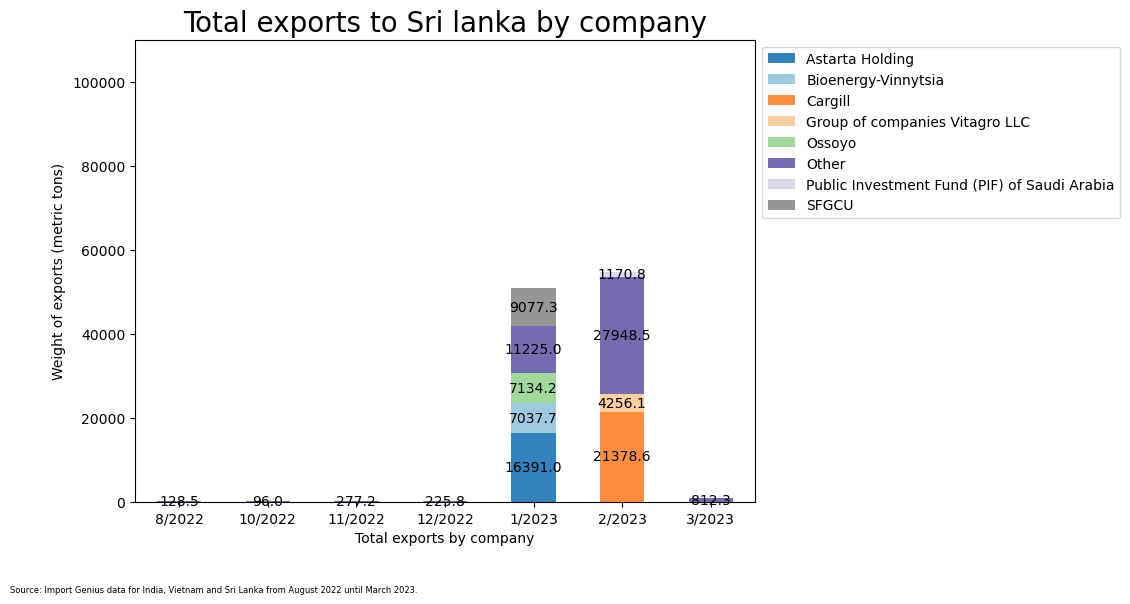

In [22]:
country_d = {"india": "індія", "viet nam": "в єтнам", "sri lanka": "шрі ланка"}

for country_en, country_uk in country_d.items():
    ig_country = ig_c[ig_c["country"] == country_uk]
    pivot_country = create_wide_table(ig_country, ["year", "month", "company_std"], ["weight_ton"], ["year", "month", "company_std"], True, {"weight_ton": "sum"})
    plot_stack_bar(pivot_country, "Total exports by company", "Weight of exports (metric tons)", f"Total exports to {country_en.capitalize()} by company", "date", 110000, "Import Genius data for India, Vietnam and Sri Lanka from August 2022 until March 2023")

Now we plot the same stacked bars with percentages but for the whole period of August 2022 until March 2023.

Values passed to ax.pie:
 0     160939.2976
1     123294.1390
2      58324.2000
3      23874.4200
4      22918.3040
5      21447.1000
6      21378.6240
7      21151.7900
8      18015.1320
9      16680.7950
10     14801.9590
11     12911.6000
12     12084.1840
13     12061.5610
14     12001.5400
15     10457.4910
16      9155.7610
17      9077.3000
18      8742.4300
19      8414.4600
20      7500.0000
21      7134.1900
22      7000.0000
23      6793.3000
24      6087.1480
25      6070.7840
26      6063.7180
27      5747.2690
28      4627.8480
29      4617.6960
30      4256.0710
31      3754.1300
32      3513.3600
33      3437.8610
34      3408.4200
35      3403.2500
36      3397.0920
37      3331.7500
Name: weight_ton, dtype: float64


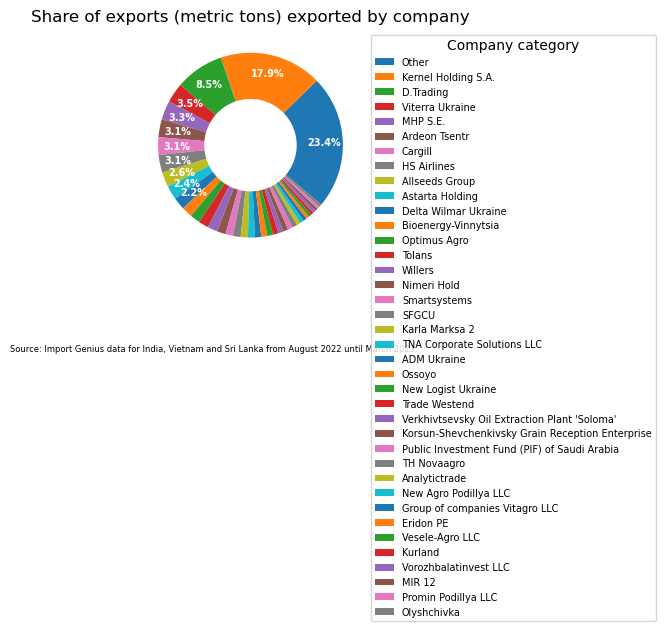

,company_std,weight_ton
0,Other,160939.2976
1,Kernel Holding S.A.,123294.1390
2,D.Trading,58324.2000
3,Viterra Ukraine,23874.4200
4,MHP S.E.,22918.3040
5,Ardeon Tsentr,21447.1000
6,Cargill,21378.6240
7,HS Airlines,21151.7900
8,Allseeds Group,18015.1320
9,Astarta Holding,16680.7950


In [23]:
# whole_period_g = cargo_grouping(ig_c, ["company_std"], ["weight_ton"], ["weight_ton"], False, {"weight_ton": "sum"})
# whole_period_g = whole_period_g.transpose().reset_index(drop=True)
# whole_period_g.columns = whole_period_g.iloc[0]
# whole_period_g = whole_period_g.iloc[1:].reset_index(drop=True)
# whole_period_g

# whole_period = whole_period_g.fillna(0)
# whole_period = whole_period.divide(whole_period.sum(axis=1), axis=0) * 100
# whole_period = whole_period.round(2)
# whole_period

# plot_stack_bar(whole_period, "Month-year", "Percentage of exports (metric tons)", "Share of exports by company", "date", 105, "Import Genius data for India, Vietnam and Sri Lanka from August 2022 until March 2023")

whole_period_g = cargo_grouping(ig_c, ["company_std"], ["weight_ton"], ["weight_ton"], False, {"weight_ton": "sum"})
whole_period_g = whole_period_g.reset_index(drop=True)
whole_period_g

plot_pie(whole_period_g["company_std"], whole_period_g["weight_ton"], "Company category", "Share of exports (metric tons) exported by company", "Import Genius data for India, Vietnam and Sri Lanka from August 2022 until March 2023", 2, 0)

whole_period_g

### TABLE WITH EXPORTS BY COMPANY (ALL COMPANIES INCLUDED)

Now we get the same table but with the specific companies that are not in the top 10 disaggregated.

In [24]:
ig_c["company_all"] = ig_c["company_std"]
for idx, row in ig_c.iterrows():
    if row["company_std"] == "Other":
        ig_c["company_all"][idx] = ig_c["shipper"][idx]

/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_49934/2768725281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_c["company_all"][idx] = ig_c["shipper"][idx]
/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_49934/2768725281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_c["company_all"][idx] = ig_c["shipper"][idx]
/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_49934/2768725281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [25]:
ig_all_comp = cargo_grouping(ig_c, ["year", "month", "company_all"], ["weight_ton"], ["year", "month", "weight_ton"], True, {"weight_ton": "sum"})
ig_all_comp["date"] = ig_all_comp["month"].astype(str) + "/" + ig_all_comp["year"].astype(str)
ig_all_comp = ig_all_comp.sort_values(by=["year", "month", "weight_ton"], ascending=[True, True, False])
translate_column(ig_all_comp, "company_all", "google", source="uk", target="en")

In [ ]:
ig_all_translate = ig_all_comp[["date", "company_all", "company_all_gt", "weight_ton"]]
ig_all_translate.to_csv('../data/total_exports_by_company.csv', index=False)
ig_all_translate[ig_all_translate["date"] == "10/2022"].head()

,date,company_all,company_all_gt,weight_ton
43,10/2022,Kernel Holding S.A.,Kernel Holding S.A.,41346.619
41,10/2022,HS Airlines,HS Airlines,21151.790
44,10/2022,MHP S.E.,MHP S.E.,9660.518
46,10/2022,Smartsystems,Smartsystems,9155.761
42,10/2022,Karla Marksa 2,Karl Marx 2,8742.430


In [ ]:
ig_all_translate

,date,company_all,company_all_gt,weight_ton
1,8/2022,ТОВ АГРАРНА КОМПАНІЯ ФОРВАРД 42736 СУМСЬКА ОБЛ...,TOV AGRICULTURAL COMPANY FORWARD 42736 SUMS RE...,143.262
3,8/2022,ТОВ БАЙРАК ТРЕЙД 2022 УКРАЇНА 65078 ОДЕСЬКА ОБ...,BAYRAK TRADE LLC 2022 UKRAINE 65078 ODESKA REG...,128.500
4,8/2022,ТОВ УКРОЛІЯ ВУЛ ШОВКОВИЧНА БУДИНОК 42 44 ОФІС ...,LLC UKROLYA STREET SHOVKOVYCHNA BUILDING 42 44...,115.060
2,8/2022,ТОВ АРСБУК УКРАЇНА ЧЕРНІВЕЦЬКА ОБЛ МІСТО ЧЕРНІ...,LLC ARSBUK UKRAINE CHERNIVETSKA OBL CITY OF CH...,70.180
0,8/2022,ПП ВІКТОР І К 27552 УКРАЇНА КІРОВОГРАДСЬКА ОБЛ...,PP VIKTOR I K 27552 UKRAINE KIROVOGRADSKA OBL ...,23.500
...,...,...,...,...
292,3/2023,ТОВ РСМ ПЛЮС 36020 ПОЛТАВА ВУЛ ОРЛИКА ПИЛИПА Б...,LLC RSM PLUS 36020 POLTAVA ORLYKA STREET PYLYP...,54.000
286,3/2023,ТОВ БУДЛІС ЕКСПОРТ 41023 СУМСЬКА ОБЛ ШОСТКИНСЬ...,BUDLYS EXPORT LLC 41023 SUMSKA REGION SHOSTKIN...,53.870
283,3/2023,ТОВ АГРО СЕРВІС НЕРУБАЙСЬКЕ 67661 ОДЕСЬКА ОБЛ ...,AGRO SERVICE NERUBAYSKE LLC 67661 ODESK OBL BI...,52.000
296,3/2023,ТОВ ФАКТОРІЯ АГРО ВУЛ НОВОПРОМИСЛОВА БУД 1 УКР...,TOV FAKTORIA AGRO VUL NOVOPROMYSLOVA BUILDING ...,48.000


### EXPLORATORY ANALYSIS FOR MANUAL COMPANY MATCHING

In [ ]:
tempo = cargo_grouping(ig_c, ["company_all"], ["weight_ton"], ["weight_ton"], True, {"weight_ton": "sum"})
tempo.sort_values(by=["weight_ton"], ascending=False)[:40]

,company_all,weight_ton
10,Kernel Holding S.A.,123294.139
6,D.Trading,58324.200
25,Viterra Ukraine,23874.420
12,MHP S.E.,22918.304
2,Ardeon Tsentr,21447.100
5,Cargill,21378.624
8,HS Airlines,21151.790
1,Allseeds Group,18015.132
7,Delta Wilmar Ukraine,14801.959
4,Bioenergy-Vinnytsia,12911.600


In [ ]:
tempo.loc[139]["company_all"]

'ТОВ ОЛИШІВКА 15575 ЧЕРНІГІВСЬКА ОБЛ ЧЕРНІГІВСЬК Р Н СМТ ОЛИШІВКА В ЧЕРНІГІВСЬКА Б'

In [ ]:
ig_c[ig_c["shipper"] == 'ТОВ ОЛИШІВКА 15575 ЧЕРНІГІВСЬКА ОБЛ ЧЕРНІГІВСЬК Р Н СМТ ОЛИШІВКА В ЧЕРНІГІВСЬКА Б']["product"]

1492    пшениця і суміш пшениці та жита (меслин): - ін...
Name: product, dtype: object

In [ ]:
deals_c[deals_c["Top parent companies"].str.lower().str.contains("oly")]["Top parent companies"]

2425                      Volynzernoproduct LLC#5023#
5784    Yelyseysʹki polya LLC (Champs Elysées)#43899#
Name: Top parent companies, dtype: object

In [ ]:
sorted(deals_c["Top parent companies"].unique())

['AGR Invest Holding Ltd#40757#',
 'AGT Capital Management Ltd.#41248#',
 'Agro Ukraina AB#44407#',
 'Agro-Podillya i K LLC#43419#',
 'AgroGeneration#656#',
 'AgroGeneration#656#|Azent Ltd.#40783#',
 'AgroGeneration#656#|L`ost Dominic#41121#|Mandua Catrin#41123#|Claud Mandua#41124#',
 'Agromino A/S#4970#',
 'Agroton Public Limited#38647#',
 'Agrovista Limited#41491#',
 'Akella Impex LP#5042#',
 'Aladin tekstil ve hiyim iuriunleri tidzharet LLC#44904#',
 'Alberto Kazoni#5062#|Kyrylenko Volodymyr#5063#|Vorotyntsev Vitaliy#5064#',
 'Albus Gunter#41907#',
 'Alexander Wolters#41898#',
 'Alpha-Capital LLC#44409#',
 'Aslan Global Management#1779#',
 'BKW Group LLC#43027#',
 'Berend Popke van der Velde#40762#|Herrit Tonkens#40763#|Huzinha Kornelius Hendrick#40764#|Oxana Kryachko#40765#',
 'Berry Farma ApS#5060#',
 'Bitex Trade Ltd.#43046#',
 'Bontrup Holding#4963#',
 'Brunner&Partner LLC#5047#|Glendore Holding LLC#5048#',
 "Brykivs'ke LLC#43422#",
 'CNBM International energy PTE.LTD#44677#',
 

### DIFFERENCE IN EXPORTS BETWEEN IG AND BSGI

We do some analysis to see why we have differences in weights between IG and BSGI

In [ ]:
ig_g = cargo_grouping(ig_c, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "IG"})
ig_g["date"] = ig_g["month"].astype(str) + "/" + ig_g["year"].astype(str)
ig_g = ig_g.drop(['year', 'month'], axis=1)
ig_g = ig_g[["date", "IG"]]

bsgi_g = cargo_grouping(bsgi_asia, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "BSGI"})
bsgi_g["date"] = bsgi_g["month"].astype(str) + "/" + bsgi_g["year"].astype(str)
bsgi_g = bsgi_g.drop(['year', 'month'], axis=1)
bsgi_g = bsgi_g[["date", "BSGI"]]

final = ig_g.merge(bsgi_g, on="date", suffixes=("_ig", "_bsgi")).round(1)
final

,date,IG,BSGI
0,8/2022,480.5,19100
1,9/2022,101447.0,106500
2,10/2022,204440.4,198789
3,11/2022,16395.7,6010
4,12/2022,96214.6,136500
5,1/2023,131385.2,92500
6,2/2023,74775.0,73444
7,3/2023,62737.6,94000


Text(-90, -60, 'Source: IG and BSGI exports to India, Vietnam and Sri Lanka from August 2022 until March 2023.')

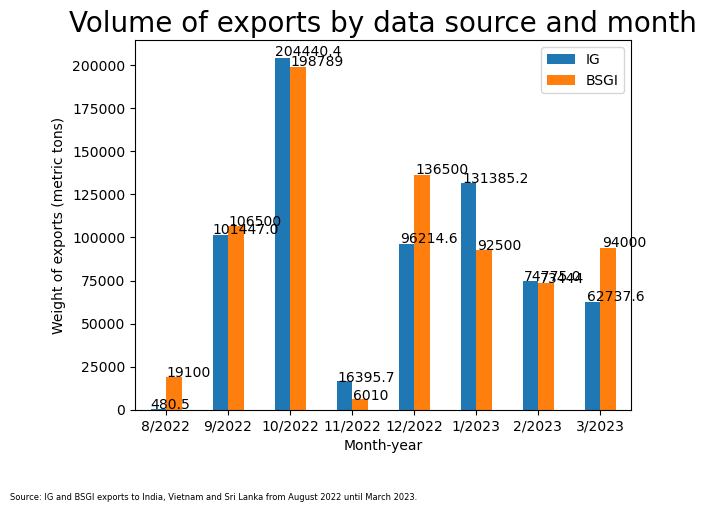

In [ ]:
ax = final.plot.bar(rot=0)
ax.set_title("Volume of exports by data source and month", fontsize=20)
ax.set_xticklabels(final["date"], rotation=0)
ax.set_xlabel("Month-year")
ax.set_ylabel("Weight of exports (metric tons)")
for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.annotate(f"Source: IG and BSGI exports to India, Vietnam and Sri Lanka from August 2022 until March 2023.", (0,0), (-90,-60), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')

We do the same for Vietnam

In [ ]:
ig_vietnam = ig_c.loc[ig_c.loc[:, "country"] == "в єтнам"]
ig_g = cargo_grouping(ig_vietnam, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "IG"})
ig_g["date"] = ig_g["month"].astype(str) + "/" + ig_g["year"].astype(str)
ig_g = ig_g.drop(['year', 'month'], axis=1)
ig_g = ig_g[["date", "IG"]]

bsgi_vietnam = bsgi_asia.loc[bsgi_asia.loc[:, "country_en"] == "viet nam"]
bsgi_g = cargo_grouping(bsgi_vietnam, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "BSGI"})
bsgi_g["date"] = bsgi_g["month"].astype(str) + "/" + bsgi_g["year"].astype(str)
bsgi_g = bsgi_g.drop(['year', 'month'], axis=1)
bsgi_g = bsgi_g[["date", "BSGI"]]

final = ig_g.merge(bsgi_g, on="date", how="outer", suffixes=("_ig", "_bsgi")).round(1)
final

,date,IG,BSGI
0,8/2022,119.4,NaN
1,9/2022,575.6,NaN
2,10/2022,110144.8,116789.0
3,11/2022,7542.4,NaN
4,12/2022,808.0,NaN
5,1/2023,520.0,NaN
6,2/2023,423.1,NaN
7,3/2023,54864.0,52000.0


Text(-90, -60, 'Source: IG and BSGI exports to Vietnam from August 2022 until March 2023.')

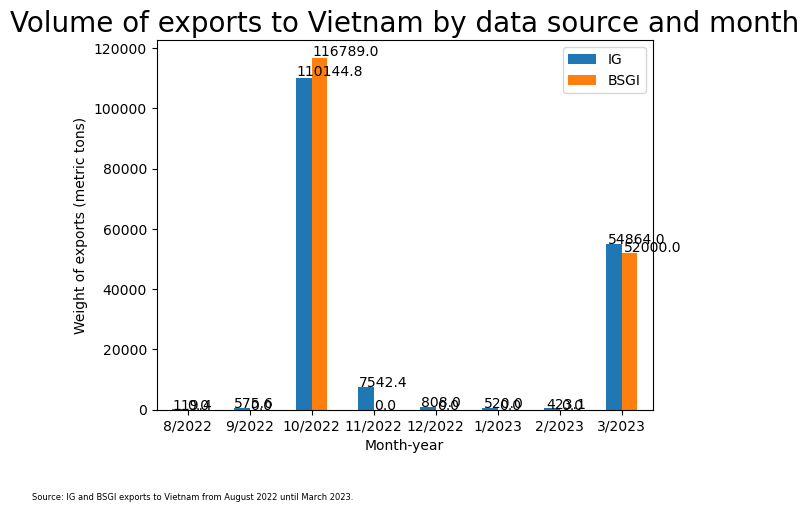

In [ ]:
ax = final.plot.bar(rot=0)
ax.set_title("Volume of exports to Vietnam by data source and month", fontsize=20)
ax.set_xticklabels(final["date"], rotation=0)
ax.set_xlabel("Month-year")
ax.set_ylabel("Weight of exports (metric tons)")
for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.annotate(f"Source: IG and BSGI exports to Vietnam from August 2022 until March 2023.", (0,0), (-90,-60), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')

In [ ]:
# dates = ["2022-08-01", "2022-09-01", "2022-10-01", "2022-11-01", "2022-12-01", "2023-01-01", "2023-02-01", "2023-03-01", "2023-04-01"]
# ig_test = ig_asia[ig_asia["bsgi_commodity"]!= "Not in BSGI"]
# for i in range(len(dates)-1):
#     ig_oct = ig_test.loc[(ig_test.loc[:, "date"] >= dates[i]) & (ig_test.loc[:, "date"] < dates[i+1])]
#     bsgi_oct = bsgi_asia.loc[(bsgi_asia.loc[:, "date"] >= dates[i]) & (bsgi_asia.loc[:, "date"] < dates[i+1])]
#     print(dates[i])
#     print("IG tons:", ig_oct.loc[ig_oct.loc[:, "country"] == "в єтнам"]["weight_ton"].sum())
#     print("BSGI tons:",bsgi_oct.loc[bsgi_oct.loc[:, "country_en"] == "viet nam"]["weight_ton"].sum())

In [ ]:
bsgi.loc[(bsgi.loc[:, "date"] >= "2022-10-01") & (bsgi.loc[:, "date"] < "2022-11-01") & (bsgi.loc[:, "country_en"] == "viet nam")].head()

,status,,vessel_name,imo,departure_port,country_en,product,weight_ton,date,inspection_cleared,...,un_region,development_category,wfp,stranded,year,month,product_std,hs_code,product_std_gt,country
717,Outbound,381,C FAITH,9575163,Odesa,viet nam,wheat,56789,2022-10-24,31-Oct-2022,...,Asia-Pacific,developing,NaN,NaN,2022,10,wheat,1001,пшениця,в'єтнам
819,Outbound,287,CORNELIA M,9490117,Yuzhny/Pivdennyi,viet nam,wheat,60000,2022-10-08,31-Oct-2022,...,Asia-Pacific,developing,NaN,NaN,2022,10,wheat,1001,пшениця,в'єтнам


# SPAIN

In [ ]:
# First we import the csv file
ig_spain = import_data("/Users/jmacedoc/Documents/DSI/Ukraine Agricultural Exports/oakland-institute-ukraine/data/ig_spain_22-23.csv", "ig")
ig_spain["company_searched"] = ig_spain["SHIPPER"]
ig_spain = rename_columns(ig_spain, "ig")

ig_spain["year"] = ig_spain["date"].dt.year
ig_spain["month"] = ig_spain["date"].dt.month

ig_spain["weight_ton"] = ig_spain["weight_kg"] / 1000
product_std = set(PRODUCTS_VAL)

ig_spain
product_std
# We create a variable that sums the number of products mentioned in the
# product name
ig_spain["n_products"] = 0
for product in product_std:
    product_uk = GoogleTranslator("en", "uk").translate(product)
    ig_spain[product] = ig_spain["product"].apply(lambda x: True if product_uk in x.lower() else False)
    ig_spain["n_products"] += ig_spain[product]

columns = ["country", "product"]
for col in columns:
    clean_column(ig_spain, col)

ig_spain["country"].unique()

array(['іспанія'], dtype=object)

In [ ]:
bsgi_spain = bsgi[(bsgi["date"] >= "2022-08-01") & (bsgi["date"] < "2023-04-01") & ((bsgi["country_en"] == "spain"))]
bsgi_spain.head()

,status,,vessel_name,imo,departure_port,country_en,product,weight_ton,date,inspection_cleared,...,un_region,development_category,wfp,stranded,year,month,product_std,hs_code,product_std_gt,country
169,Outbound,858,SANITA S,9237888,Chornomorsk,spain,corn,40500,2023-03-30,7-Apr-2023,...,Western Europe and Others,developed,NaN,NaN,2023,3,corn,1005,кукурудза,іспанія
172,Outbound,855,XIN YU,9244362,Chornomorsk,spain,corn,27671,2023-03-29,8-Apr-2023,...,Western Europe and Others,developed,NaN,NaN,2023,3,corn,1005,кукурудза,іспанія
185,Outbound,845,FAIR LADY,9342877,Chornomorsk,spain,corn,45044,2023-03-25,4-Apr-2023,...,Western Europe and Others,developed,NaN,NaN,2023,3,corn,1005,кукурудза,іспанія
203,Outbound,829,NEW ISLAND,9258349,Chornomorsk,spain,corn,42000,2023-03-20,29-Mar-2023,...,Western Europe and Others,developed,NaN,NaN,2023,3,corn,1005,кукурудза,іспанія
206,Outbound,827,SSI PRIDE,9250579,Chornomorsk,spain,wheat,47000,2023-03-19,28-Mar-2023,...,Western Europe and Others,developed,NaN,NaN,2023,3,wheat,1001,пшениця,іспанія


In [ ]:
ig_spain["shipper_low"] = ig_spain["shipper"].str.lower()

ig_c = ig_spain.copy()
ig_c["company_std"] = standard_company_name(ig_spain["shipper_low"], subsidiaries_c)
ig_c["company_std"].unique()



/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_26795/1418912375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_spain["shipper_low"] = ig_spain["shipper"].str.lower()


array(['Other', 'Viterra Ukraine', 'MHP S.E.', 'KSG Agro SA',
       'Astarta Holding', 'Group of companies Vitagro LLC',
       'Kernel Holding S.A.', 'Willers', 'NCH Capital Inc.',
       'Public Investment Fund (PIF) of Saudi Arabia',
       'Industrial Milk Company (IMC) S.A.', 'Cargill', 'MIR 12',
       'Olyshchivka', 'UkrLandFarming PLC', 'Karla Marksa 2',
       'Ardeon Tsentr', 'ADM Ukraine', 'New Agro Podillya LLC',
       'System Capital Management (SCM)', 'Burat-Agro LLC',
       'Agroton Public Limited', 'Nibulon', 'New Logist Ukraine',
       'Allseeds Group', 'Vorozhbalatinvest LLC', 'TH Novaagro'],
      dtype=object)

Values passed to ax.pie:
 0     4004923.823
1      231409.341
2       95709.952
3       58581.219
4       45330.929
5       40092.420
6       38868.115
7       33923.755
8       20862.013
9       18109.080
10      13075.962
11       9302.877
12       6805.147
13       6675.825
14       4630.000
15       4423.531
16       3343.869
17       3328.175
18       2915.337
19       2651.900
20       2020.710
21       1865.670
22       1597.730
23       1295.600
24        841.568
25        566.795
26        420.260
Name: weight_ton, dtype: float64


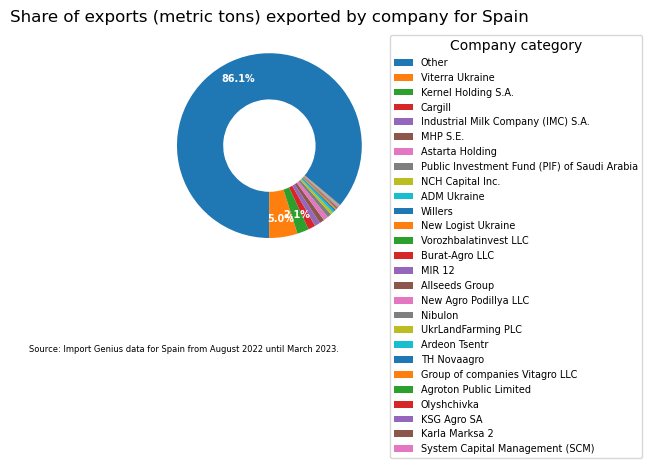

,company_std,weight_ton
0,Other,4004923.823
1,Viterra Ukraine,231409.341
2,Kernel Holding S.A.,95709.952
3,Cargill,58581.219
4,Industrial Milk Company (IMC) S.A.,45330.929
5,MHP S.E.,40092.420
6,Astarta Holding,38868.115
7,Public Investment Fund (PIF) of Saudi Arabia,33923.755
8,NCH Capital Inc.,20862.013
9,ADM Ukraine,18109.080


In [ ]:
whole_period_g = cargo_grouping(ig_c, ["company_std"], ["weight_ton"], ["weight_ton"], False, {"weight_ton": "sum"})
whole_period_g = whole_period_g.reset_index(drop=True)
whole_period_g

plot_pie(whole_period_g["company_std"], whole_period_g["weight_ton"], "Company category", "Share of exports (metric tons) exported by company for Spain", "Import Genius data for Spain from August 2022 until March 2023", 2, 0)

whole_period_g

In [ ]:
print("IG tons:",ig_spain["weight_ton"].sum())
print("BSGI tons:",bsgi_spain["weight_ton"].sum())

IG tons: 4653571.603
BSGI tons: 4521818
